# Unsupervised Workflows

In the previous chapters we established a solid foundation in supervised learning, complete with knowledge of deploying models in production but always assumed that a labeled dataset would be available for our analysis. In this chapter, we take on the challenge of modeling data without any, or with very few, labels. This takes us into a journey into anomaly detection, a kind of unsupervised modeling, as well as distance-based learning, where beliefs about what constitutes similarity between two examples can be used in place of labels to help us achieve levels of accuracy comparable to a supervised workflow. Upon completing this chapter, we will clearly stand out from the crowd of data scientists in confidently knowing what tools to use to modify our workflow in order to overcome common real-world challenges.

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.feature_selection import chi2, SelectKBest, f_classif

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import IsolationForest as isof
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import LocalOutlierFactor as lof
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import OneClassSVM as onesvm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, make_scorer
from sklearn.metrics import DistanceMetric as dm

from sklearn.pipeline import Pipeline

from scipy.spatial.distance import squareform, pdist
import stringdist

## Anomaly detection

When we first encounter a new type of algorithm, it is always a great idea to test it with a very simple example. So we decide to create a list containing thirty examples with the value 1.0 and just one example with value 10.0, which we expect should be flagged as an outlier. To make sure we use the algorithm correctly, we convert the list to a pandas dataframe, and feed it into the local outlier factor algorithm.

In [3]:
# Create the list [1.0, 1.0, ..., 1.0, 10.0] as explained
x = [1.0]*30
x.append(10.0)

# Cast to a data frame
X = pd.DataFrame(x)

# Fit the local outlier factor and print the outlier scores
print(lof().fit_predict(X))

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1]


The algorithm correctly identified the 10.0 as an outlier since it labeled it -1 which stands for anomalous. Let's move on.

Our medical advisor at the arrhythmia startup informs us that our training data might not contain all possible types of arrhythmia. How on earth will we detect these other types without any labeled examples? Could an anomaly detector tell the difference between healthy and unhealthy without access to labels? But first, we experiment with the contamination parameter to see its effect on the confusion matrix.

In [14]:
arrh = pd.read_csv('data/arrh.csv')

X, ground_truth = arrh.drop('class', axis=1), arrh['class']
ground_truth.loc[ground_truth == 0] = -1

C:\Users\DmitriGazizulin\AppData\Local\Temp\ipykernel_488\3722105992.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ground_truth.loc[ground_truth == 0] = -1


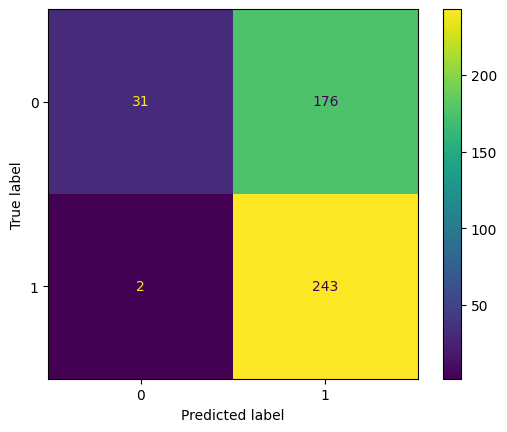

In [38]:
# Fit the local outlier factor and output predictions
preds = lof().fit_predict(X)


# Print the confusion matrix
# print(confusion_matrix(ground_truth, preds))

cm = confusion_matrix(ground_truth, preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

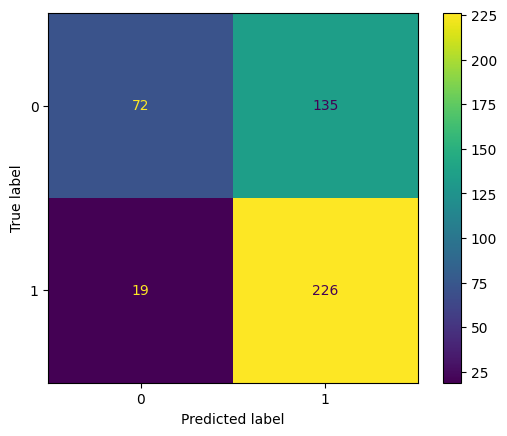

In [39]:
# Set the contamination parameter to 0.2
preds = lof(contamination=0.2).fit_predict(X)

# Print the confusion matrix
# print(confusion_matrix(ground_truth, preds))

cm = confusion_matrix(ground_truth, preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

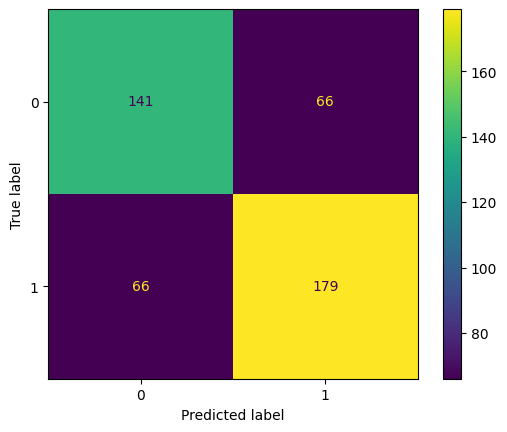

In [40]:
# Contamination to match outlier frequency in ground_truth
preds = lof( contamination=np.mean(ground_truth == -1.0)).fit_predict(X)

# Print the confusion matrix
# print(confusion_matrix(ground_truth, preds))

cm = confusion_matrix(ground_truth, preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [20]:
np.mean(ground_truth == -1.0)

0.4579646017699115

We now have much more control over the local outlier factor algorithm.

## Novelty detection

We find novelty detection more useful than outlier detection, but want to make sure it works on the simple example we came up with before. This time we will use a sequence of thirty examples all with value 1.0 as a training set, and try to see if the example 10.0 is labeled as a novelty.

In [21]:
# Create a list of thirty 1s and cast to a dataframe
X = pd.DataFrame([1.0]*30)

# Create an instance of a lof novelty detector
detector = lof(novelty=True)

# Fit the detector to the data
detector.fit(X)

# Use it to predict the label of an example with value 10.0
print(detector.predict(pd.DataFrame([10.0])))

[-1]


Great, we are now reassured that we understand the method correctly: 10.0 is labelled as -1, which means it is considered novel.

Finally, we know enough to run some tests on the use of a few anomaly detectors on the arrhythmia dataset. To test their performance, we will train them on an unlabeled training dataset, but then compare their predictions to the ground truth on the test data using their method `.score_samples()`.

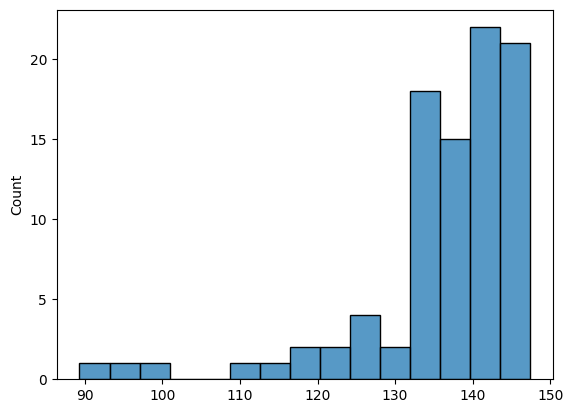

In [28]:
arrh = pd.read_csv('data/arrh.csv')
# arrh['class'] = arrh['class'] == 'bad'
X, y = arrh.drop('class', axis=1), arrh['class']

# Split the data into train and test, with 20% as test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Fit it to the training data and score the test data
svm_detector = onesvm().fit(X_train)
scores = svm_detector.score_samples(X_test)

sns.histplot(scores)
plt.show()

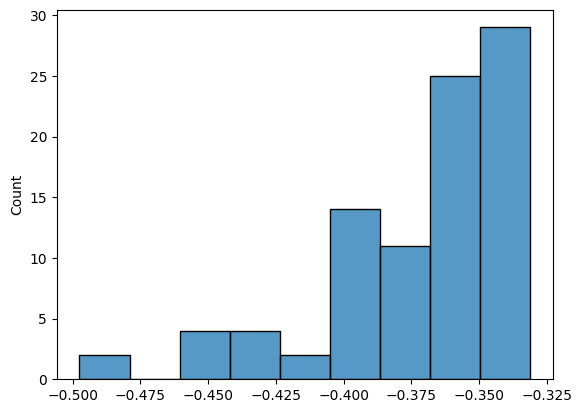

In [31]:
# Fit it to the training data and score the test data
svm_detector = isof().fit(X_train)
scores = svm_detector.score_samples(X_test)

sns.histplot(scores)
plt.show()

C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


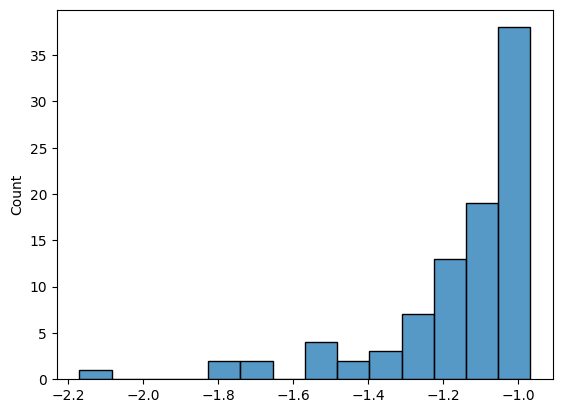

In [33]:
# Fit it to the training data and score the test data
lof_detector = lof(novelty=True).fit(X_train)
scores = lof_detector.score_samples(X_test)

sns.histplot(scores)
plt.show()

We now have a broad selection of detectors to choose from.

We notice that one-class SVM does not have a contamination parameter. But we know well by now that we really need a way to control the proportion of examples that are labeled as novelties in order to control our false positive rate. So we decide to experiment with thresholding the scores. 

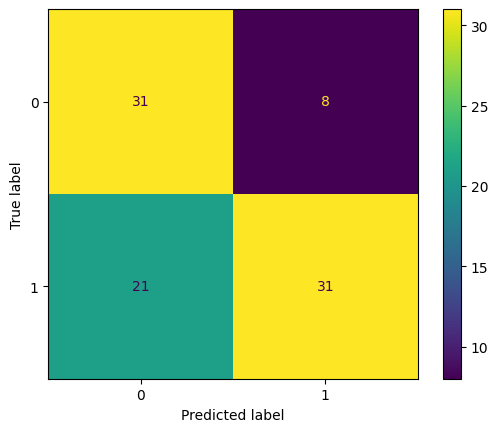

In [41]:
# Fit a one-class SVM detector and score the test data
nov_det = onesvm().fit(X_train)
scores = nov_det.score_samples(X_test)

# Find the observed proportion of outliers in the test data
prop = np.mean(y_test==1)

# Compute the appropriate threshold
threshold = np.quantile(scores, prop)

# Print the confusion matrix for the thresholded scores
# print(confusion_matrix(y_test, scores > threshold))
cm = confusion_matrix(y_test, scores > threshold)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

We now have the same amount of control over one-class SVM as we do over other detectors.

## Distance-based learning

It is clear that the local outlier factor algorithm depends a lot on the idea of a nearest neighbor, which in turn depends on the choice of distance metric. So we decide to experiment some more with the hepatitis dataset. We are given three examples stored in `features`, whose classes are stored in `labels`. We will identify the nearest neighbor to the first example (row with index 0) using three different distance metrics, Euclidean, Hamming and Chebyshev, and on the basis of that choose which distance metric to use.

- 'sex': 'male' = 1, 'female' = 0
- 'class': 'live' = 2, 'die' = 1

In [65]:
hepatitis = pd.read_csv('data/hepatitis_csv.csv')
hepatitis.dropna(inplace=True)
hepatitis['sex'].replace({'male': 1, 'female': 0}, inplace=True)
hepatitis['class'].replace({'live': 2, 'die': 1}, inplace=True)
hepatitis = hepatitis*1
hepatitis.head()

age  sex steroid  antivirals fatigue malaise anorexia liver_big  \
5    34    0       1           0       0       0        0         1   
10   39    0       0           1       0       0        0         0   
11   32    0       1           1       1       0        0         1   
12   41    0       1           1       1       0        0         1   
13   30    0       1           0       1       0        0         1   

   liver_firm spleen_palpable spiders ascites varices  bilirubin  \
5           0               0       0       0       0        0.9   
10          1               0       0       0       0        1.3   
11          1               0       1       0       0        1.0   
12          1               0       0       0       0        0.9   
13          1               0       0       0       0        2.2   

    alk_phosphate   sgot  albumin  protime  histology  class  
5            95.0   28.0      4.0     75.0          0      2  
10           78.0   30.0      4.4     85.0          0      2  
11           59.0  249.0      3.7     54.0          0      2  
12           81.0   60.0      3.9     52.0          0      2  
13           57.0  144.0      4.9     78.0          0      2

In [71]:
features, labels = hepatitis.drop('class', axis=1), hepatitis['class']

# Find the Euclidean distance between all pairs
dist_eucl = dm.get_metric('euclidean').pairwise(features.head(4))
print(dist_eucl)
print("#"*40)

# Find the Hamming distance between all pairs
dist_hamm = dm.get_metric('hamming').pairwise(features.head(4))
print(dist_hamm)
print("#"*40)

# Find the Chebyshev distance between all pairs
dist_cheb = dm.get_metric('chebyshev').pairwise(features.head(4))
print(dist_cheb)

[[  0.          20.55042579 224.91353894  42.43830817]
 [ 20.55042579   0.         222.11839185  44.78180434]
 [224.91353894 222.11839185   0.         190.50209973]
 [ 42.43830817  44.78180434 190.50209973   0.        ]]
########################################
[[0.         0.52631579 0.52631579 0.42105263]
 [0.52631579 0.         0.52631579 0.47368421]
 [0.52631579 0.52631579 0.         0.36842105]
 [0.42105263 0.47368421 0.36842105 0.        ]]
########################################
[[  0.  17. 221.  32.]
 [ 17.   0. 219.  33.]
 [221. 219.   0. 189.]
 [ 32.  33. 189.   0.]]


In the previous exercise we saw that not all metrics agree when it comes to identifying nearest neighbors. But does this mean they might disagree on outliers, too? Wק decide to put this to the test. Wק use the same data as before, but this time feed it into a local outlier factor outlier detector.

In [72]:
# Compute outliers according to the euclidean metric
out_eucl = lof(metric='euclidean').fit_predict(features.head(4))

# Compute outliers according to the hamming metric
out_hamm = lof(metric='hamming').fit_predict(features.head(4))

# Compute outliers according to the jaccard metric
out_jacc  =lof(metric='jaccard').fit_predict(features.head(4))

# Find if the metrics agree on any one datapoint
print(any(out_eucl + out_hamm + out_jacc == -3))

False


C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\neighbors\_lof.py:274: UserWarning: n_neighbors (20) is greater than the total number of samples (4). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\neighbors\_lof.py:274: UserWarning: n_neighbors (20) is greater than the total number of samples (4). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\neighbors\_lof.py:274: UserWarning: n_neighbors (20) is greater than the total number of samples (4). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


There is no datapoint that all three metrics flag as an outlier. So choosing a distance metric should be done with great caution! We now have a concrete understanding of the effect of distance metrics on outlier detection.

## Unstructured data

We notice that the `stringdist` package also implements a variation of Levenshtein distance called the Restricted Damerau-Levenshtein distance, and want to try it out. We will follow the logic from the lesson, wrapping it inside a custom function and precomputing the distance matrix before fitting a local outlier factor anomaly detector. We will measure performance with `accuracy_score()`. 

In [76]:
proteins = pd.read_csv('data/proteins_exercises.csv')
proteins

label                                                seq
0   IMMUNE SYSTEM  LTKCQEEVSHIPAVHPGSFRPKCDENGNYLPLQCYGSIGYCWCVFP...
1   IMMUNE SYSTEM  GPSVFLFPPKPKDTLMISRTPEVTCVVVDVSHEDPEVKFNWYVDGV...
2   IMMUNE SYSTEM                 FNMQCQRRFYEALHDPNLNEEQRNAKIKSIRDDC
3   IMMUNE SYSTEM  EVQLVESGGGLVQPGGSLRLSCAASGFTFTDYTMDWVRQAPGKGLE...
4   IMMUNE SYSTEM  DIQMTQSPSSLSASVGDRVTITCKASQDVSIGVAWYQQKPGKAPKL...
..            ...                                                ...
95          VIRUS  ASNFTQFVLVDNGGTGDVTVAPSNFANGVAEWISSNSRSQAYKVAC...
96          VIRUS  ASNFTQFVLVDNGGTGDVTVAPSNFANGVAEWISSNSRSQAYKVTC...
97  IMMUNE SYSTEM  QVQLVESGGGSVQAGGSLRLSCAASGFTYSRKYMGWFRQAPGKERE...
98  IMMUNE SYSTEM  MIHSSVKRWGNSPAVRIPATLMQALNLNIDDEVKIDLVDGKLIIEP...
99  IMMUNE SYSTEM  DIVMTQSPSSLTVTAGEKVTMSCKSSQSLLNSGNQKNYLTWYQQKP...

[100 rows x 2 columns]

In [86]:
%%time
# Wrap the RD-Levenshtein metric in a custom function
def my_rdlevenshtein(u, v):
    return stringdist.rdlevenshtein(u[0], v[0])

# Reshape the array into a numpy matrix
sequences = np.array(proteins['seq']).reshape(-1, 1)

# Compute the pairwise distance matrix in square form
M = squareform(pdist(sequences, my_rdlevenshtein))

# Run a LoF algorithm on the precomputed distance matrix
preds = lof(metric='precomputed').fit_predict(M)

# Compute the accuracy of the outlier predictions
print(accuracy_score(proteins['label'] == 'VIRUS', preds == -1))

0.81
CPU times: total: 3min 14s
Wall time: 3min 18s


Overcoming compatibility problems when working with different Python modules is the sign of a true expert. What's more, we should now feel confident that success is possible even without labels.

In addition to the distance-based learning anomaly detection pipeline we created in the last exercise, we want to also support a feature-based learning one with one-class SVM. We decide to extract two features: first, the length of the string, and, second, a numerical encoding of the first letter of the string, obtained using the function `LabelEncoder()` described in Chapter 1.

In [87]:
lof_detector = lof(metric='precomputed').fit(M)

In [90]:
# Create a feature that contains the length of the string
proteins['len'] = proteins['seq'].apply(lambda s: len(s))

# Create a feature encoding the first letter of the string
proteins['first'] =  LabelEncoder().fit_transform(
  proteins['seq'].apply(lambda s: list(s)[0]))

# Extract scores from the fitted LoF object, compute its AUC
scores_lof = lof_detector.negative_outlier_factor_
print(roc_auc_score(proteins['label']=='IMMUNE SYSTEM', scores_lof))

# Fit a 1-class SVM, extract its scores, and compute its AUC
svm = onesvm().fit(proteins[['len', 'first']])
scores_svm = svm.score_samples(proteins[['len', 'first']])
print(roc_auc_score(proteins['label']=='IMMUNE SYSTEM', scores_svm))

0.739375
0.6959375
